Modify the scratch code of gaussian mixture clustering in our lecture:
- Modify so it performs early stopping when the log likelihood does not improve anymore.  Note that if you log the normal distribution, you will get negative sign.  Thus if you ignore the negative sign, it will become negative likelihood, and thus will get smaller and smaller.
- Perform plotting every 5 iterations on the resulting clusters.

In [77]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import math
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

maxll smaller?  -37452.61214710814
maxll difference:  37452.61214710814
maxll smaller?  -35047.44209425795
maxll difference:  1192.8530300935527
maxll smaller?  -110071.69782251955
maxll difference:  10765.634888082684
maxll smaller?  -164159.79113694915
maxll difference:  11596.234829457419


Text(0.5, 1.0, 'Final')

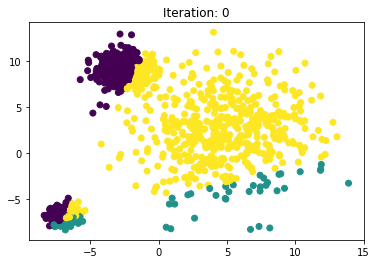

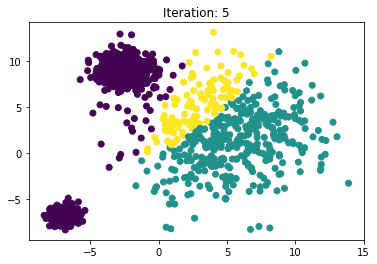

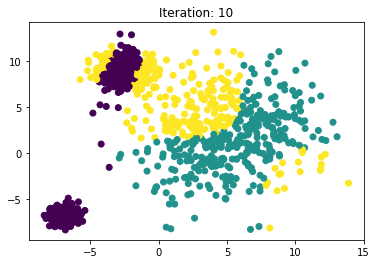

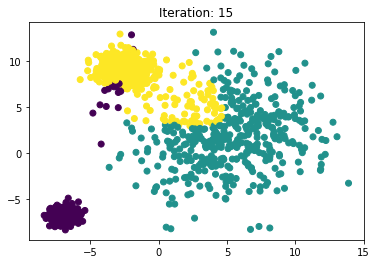

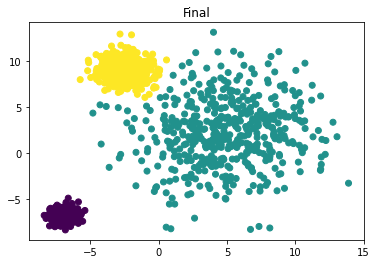

In [85]:
X, y = make_blobs(n_samples=1500, cluster_std=[1.0, 3.5, 0.5], random_state=42)

#define basic params
m, n = X.shape
K = 3
max_iter = 20
oldmaxll = 0

#==initialization==

#responsibliity
r = np.full(shape=(m, K), fill_value=1/K)
# r shape: (m, k) - the likelihood of each sample to each cluster

#pi
pi = np.full((K, ), fill_value=1/K) #simply use 1/k for pi
# pi shape: (k, ) - similar to p(y) of each cluster

#mean
random_row = np.random.randint(low=0, high=m, size=K)
mean = np.array([X[idx,:] for idx in random_row ]).T #.T to make to shape (M, K)
# mean shape: n, k (2,3) (mean for each feature for each cluster) centers for k circles

# covariance
cov = np.array([np.cov(X.T) for _ in range (K)])  # transpose because np.cov wants that
# cov shape: k, n, n (3,2,2)  (covriance matrix (n x n) for each cluster)

for iteration in range(max_iter):
    
    #===E-Step=====
    #Update r_ik of each sample
    for i in range(m):
        for k in range(K):
            xi_pdf = multivariate_normal.pdf(X[i], mean=mean[:, k], cov=cov[k])
            r[i, k] = pi[k] * xi_pdf    # p(y) * p(x | y)
        r[i] /= np.sum(r[i])            # normalize
        
    maxll = 0
    for i in range(m):                              # p(x|y)p(y)
        for k in range(K):                          # log p(x|y)p(y)
            maxll += math.log(pi[k])                # log p(X|y) log p(y)
            maxll += multivariate_normal.logpdf(    # log(p(x|y))+log(p(y))
                X[i], mean=mean[:, k], cov=cov[k])  # likelihood--higher,better
            
    if(iteration % 5 == 0):
        preds = np.argmax(r, axis=1)
        plt.figure()
        plt.scatter(X[:, 0], X[:, 1], c=preds)
        plt.title(f"Iteration: {iteration}")
        print("maxll smaller? ", maxll)
        print("maxll difference: ", math.fabs(maxll - oldmaxll))    
    
    if(math.fabs(maxll-oldmaxll) < 5):
        print("Final maxll: ", maxll)
        print("final difference: ", math.fabs(maxll - oldmaxll))
        break
    oldmaxll = maxll
    
    #===M-Step====
    # Find NK first for latter use
    NK = np.sum(r, axis=0)
    assert NK.shape == (K, )  # sum of all likelihood of each cluster
    
    #PI   update
    pi = NK / m
    assert pi.shape == (K, )
    
    #mean   update
    mean =  ( X.T @ r ) / NK
    assert mean.shape == (n, K)
    
    #covariance (also called Sigma)
    cov = np.zeros((K, n, n))
    for k in range(K):
        for i in range(m):
            X_mean = (X[i]-mean[:, k]).reshape(-1, 1)
            cov[k] += r[i, k] * (X_mean @ X_mean.T)
        cov[k] /= NK[k]
    assert cov.shape == (K, n, n)
        

#get preds
yhat = np.argmax(r, axis=1)

#plot
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=yhat)
plt.title("Final")